Here I am analysing the following data:
https://github.com/Plastic-Scanner/data/tree/main/data/20230302_avantes_spectrometer_third_dataset/

The analysis is mostly based off the work of https://pypi.org/project/pyspectra/

Author: Joost Scheffer @ 2023-03-13

In [ ]:
!pip install scikit-learn, pyspectra

In [1]:
from pathlib import Path
from pyspectra.transformers.spectral_correction import msc, detrend, snv
from sklearn.decomposition import PCA
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
!git clone https://github.com/Plastic-Scanner/data/

Cloning into 'data'...
remote: Enumerating objects: 745, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 745 (delta 85), reused 167 (delta 46), pack-reused 496
Receiving objects: 100% (745/745), 17.96 MiB | 9.05 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [3]:
!ls data/data/20230302_avantes_spectrometer_third_dataset/

A01C_PET_FDP.csv   C01C_PVC_FDP.csv   E01C_PP_FDP.csv
A02C_PET_FDP.csv   C02C_PVC_FDP.csv   E02C_PP_FDP.csv
A03C_PET_FDP.csv   C03C_PVC_FDP.csv   E03C_PP_FDP.csv
A04C_PET_FDP.csv   C04C_PVC_FDP.csv   E04C_PP_FDP.csv
A05C_PET_FDP.csv   C05C_PVC_FDP.csv   E05C_PP_FDP.csv
B01C_HDPE_FDP.csv  C06C_PVC_FDP.csv   F01C_PS_FDP.csv
B02C_HDPE_FDP.csv  D01C_LDPE_FDP.csv  F02C_PS_FDP.csv
B03C_HDPE_FDP.csv  D02C_LDPE_FDP.csv  F03C_PS_FDP.csv
B04C_HDPE_FDP.csv  D03C_LDPE_FDP.csv  F04C_PS_FDP.csv
B05C_HDPE_FDP.csv  D04C_LDPE_FDP.csv  RefSpectrum_PlSc_FDP.csv


***
# load data into dataframe

**WARNING** the third dataset is not documented, I don't know which column I should use...

In [4]:
p = Path("data/data/20230302_avantes_spectrometer_third_dataset/")
files = list(p.glob(f"*.csv"))

# WARNING: I don't know which column to use
df_dict = {
    f.stem: np.loadtxt(f, skiprows=6, delimiter=",", usecols=[5]).T for f in files
}

type_dict = {f.stem: f.stem.split("_")[1] for f in files}
wavelengths = np.loadtxt(files[0], skiprows=6, delimiter=",", usecols=[0])

filename_id = {f.stem: f.stem.split("_")[0] for f in files}

In [5]:
# from https://stackoverflow.com/a/45496015
def reverse_non_unique_mapping(d):
    dinv = {}
    for k, v in d.items():
        if v in dinv:
            dinv[v].append(k)
        else:
            dinv[v] = [k]
    return dinv

In [6]:
type_filename = reverse_non_unique_mapping(type_dict)

In [7]:
df = pd.DataFrame.from_dict(df_dict, orient="index", columns=wavelengths)

In [8]:
len(df_dict), len(wavelengths)

(30, 223)

In [9]:
df.head()

,1014.478516,1019.012782,1023.542490,1028.067635,1032.588212,1037.104217,1041.615645,1046.122493,1050.624755,1055.122428,...,1870.414962,1873.879635,1877.338819,1880.792510,1884.240704,1887.683397,1891.120583,1894.552259,1897.978420,1901.399062
E03C_PP_FDP,18401.0,19592.0,20707.0,21451.5,22347.0,23648.5,24622.0,26003.0,26202.5,26998.5,...,6094.5,5867.0,6150.0,5968.0,5984.5,5548.0,5424.0,5515.0,5783.0,5511.0
RefSpectrum_PlSc_FDP,19463.0,20813.0,22072.5,22885.5,23872.5,25301.0,26355.5,27839.0,28144.5,29007.0,...,8100.5,7840.5,8133.0,7898.0,7951.5,7457.0,7341.0,7425.5,7615.0,7303.5
B03C_HDPE_FDP,17662.5,18820.5,19882.5,20497.0,21272.5,22470.0,23372.0,24740.0,24934.5,25702.0,...,7355.5,7139.5,7421.5,7214.0,7236.5,6768.5,6654.5,6741.5,6971.5,6688.0
E01C_PP_FDP,16631.5,17718.0,18715.5,19324.0,20082.0,21214.5,22069.0,23309.5,23390.0,24053.0,...,5248.0,5032.0,5327.0,5171.5,5187.5,4778.5,4636.5,4735.0,5019.5,4743.5
C01C_PVC_FDP,24969.0,26655.5,28275.0,29359.0,30706.5,32624.5,34043.5,35880.5,36452.0,37648.0,...,9664.5,9426.5,9712.0,9477.5,9551.0,9024.0,8893.0,8962.5,9125.5,8778.0


In [10]:
colors = [
    "#ffd700",
    "#ffb14e",
    "#fa8775",
    "#ea5f94",
    "#cd34b5",
    "#9d02d7",
    "#0000ff",
    "#2194F9",
]
colors = ["r", "g", "b", "orange", "k", "m", "teal"]
ticks = [1050, 1200, 1300, 1450, 1550, 1650, 1720]

type_color = {val: colors[i] for i, val in enumerate(set(type_dict.values()))}
color = [type_color[type_dict[x]] for x in df.transpose().columns]

## apply snv transform to each spectrum measurement

In [11]:
def snv_diy(x):
    return (x - np.mean(x)) / np.std(x)

In [12]:
df_snv = df.apply(snv_diy, axis=1)

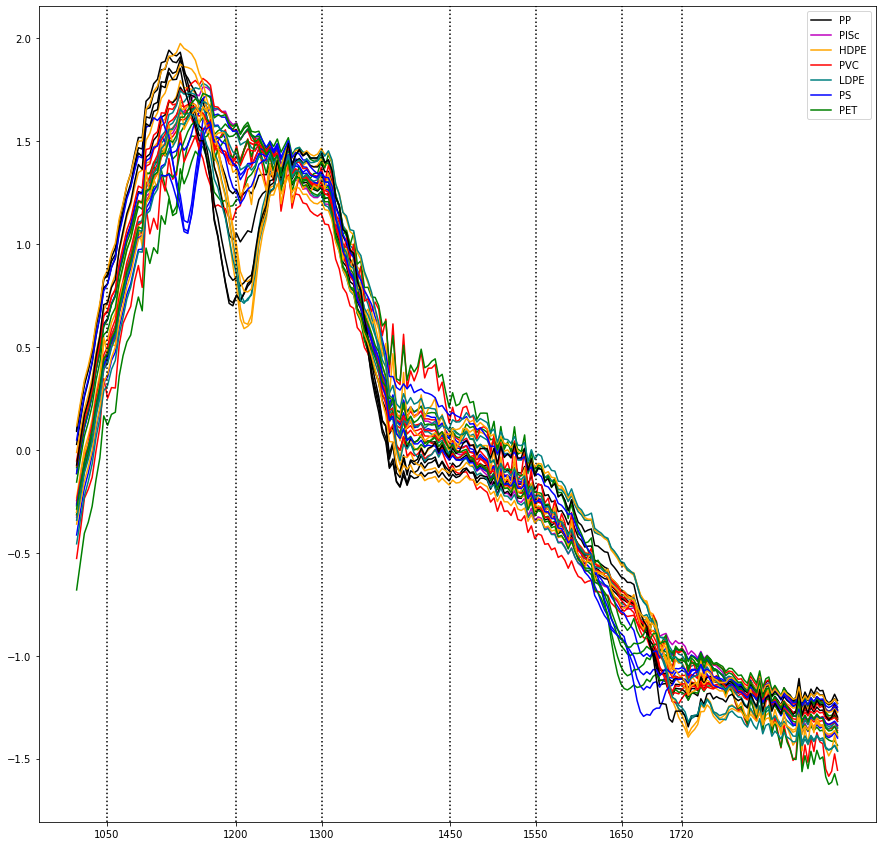

In [13]:
plt.figure(figsize=[15, 15])

had = set()
dft = df_snv.transpose()
for col in dft.columns:
    typ = type_dict[col]
    if typ not in had:
        plt.plot(dft[col], color=type_color[type_dict[col]], label=typ)
    else:
        plt.plot(dft[col], color=type_color[type_dict[col]])
    had.add(typ)

for x in ticks:
    plt.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
plt.xticks(ticks, list(map(str, ticks)))

plt.legend()
plt.show()

### plot snv spectrum per material

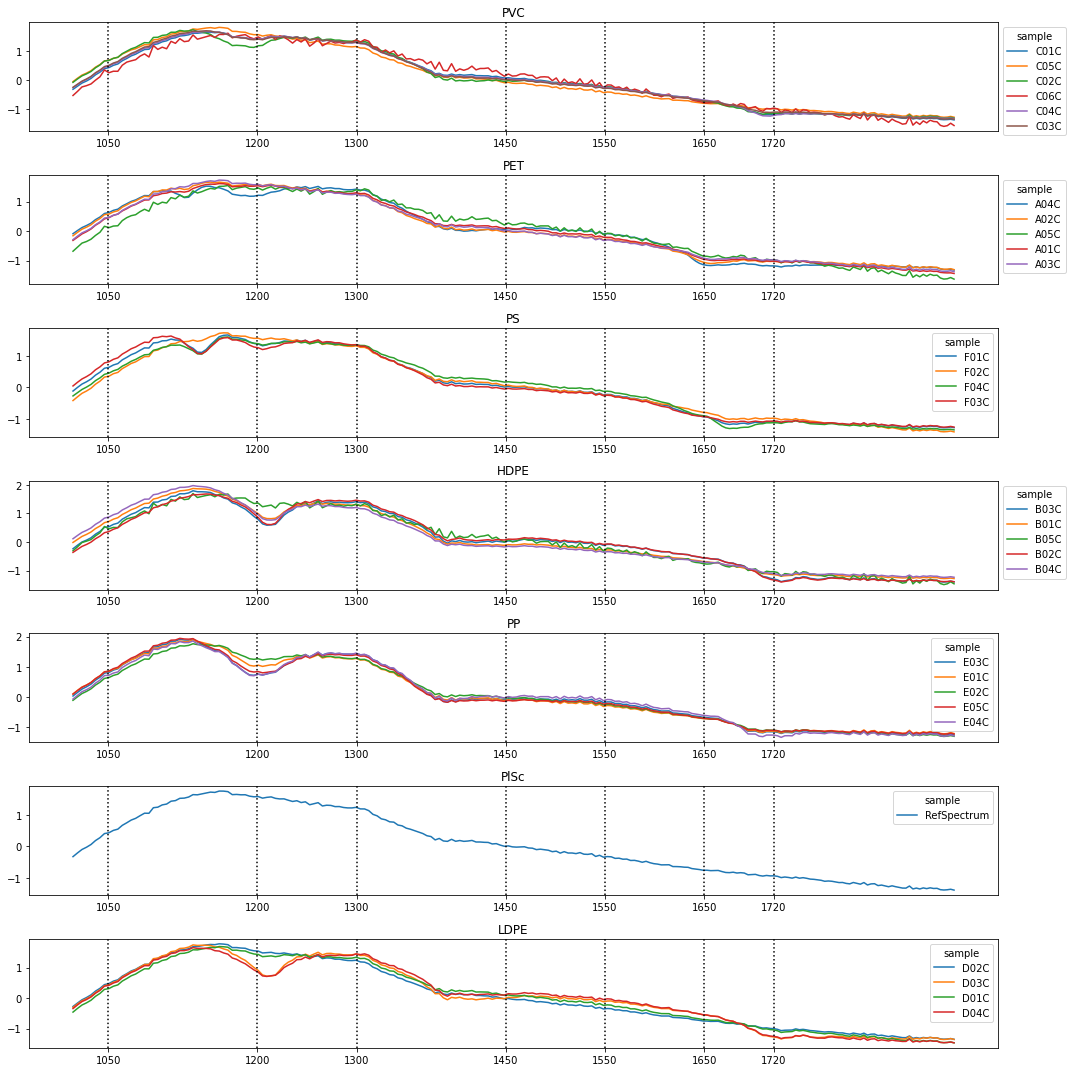

In [14]:
f, axs = plt.subplots(len(set(type_dict.values())), 1, figsize=[15, 15])
dft = df_snv.transpose()
for ax, typ in zip(axs, set(type_dict.values())):
    for file in type_filename[typ]:
        ax.plot(dft[file], label=filename_id[file])

    ax.legend(title="sample", bbox_to_anchor=(1, 1))
    ax.set_title(typ)

    for x in ticks:
        ax.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
    ax.set_xticks(ticks, list(map(str, ticks)))

plt.tight_layout()

***
## Multiplicative scattering correction (MSC)

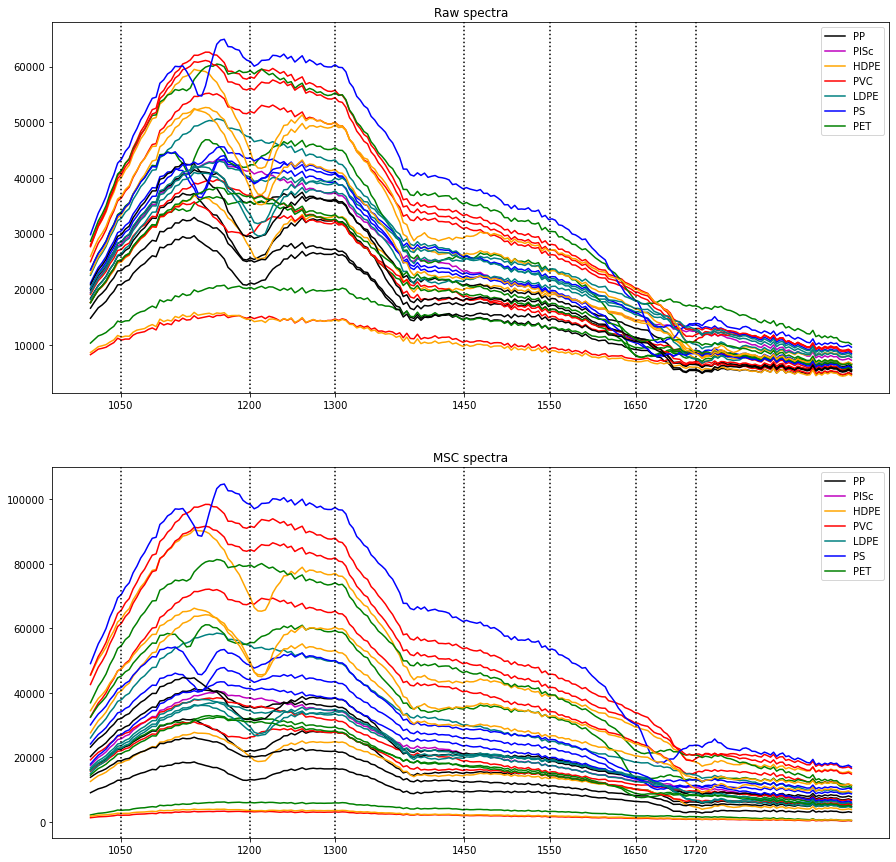

In [15]:
MSC = msc()
MSC.fit(df)
df_msc = MSC.transform(df)

f, ax = plt.subplots(2, 1, figsize=[15, 15])

had = set()
dft = df.transpose()
for col in dft.columns:
    typ = type_dict[col]
    if typ not in had:
        ax[0].plot(dft[col], color=type_color[type_dict[col]], label=typ)
    else:
        ax[0].plot(dft[col], color=type_color[type_dict[col]])
    had.add(typ)
ax[0].set_title("Raw spectra")

had = set()
dft = df_msc.transpose()
for col in dft.columns:
    typ = type_dict[col]
    if typ not in had:
        ax[1].plot(dft[col], color=type_color[type_dict[col]], label=typ)
    else:
        ax[1].plot(dft[col], color=type_color[type_dict[col]])
    had.add(typ)

ax[1].set_title("MSC spectra")

for axi in ax:
    for x in ticks:
        axi.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
    axi.set_xticks(ticks, list(map(str, ticks)))
    axi.legend(bbox_to_anchor=(1, 1))
plt.show()

## Standard normal variate (SNV) & detrend
Here snv and detrending are performed individually on each sample using functions from `pyspectra.transformers.spectral_correction`.

The detrending is done by fitting and subtracting a polynomial of degree 2 from each individual spectrum.

In [16]:
SNV = snv()
df_snv = SNV.fit_transform(df)

Detr = detrend()
df_detrend = Detr.fit_transform(spc=df_snv, wave=np.array(df_snv.columns))

In [17]:
f, ax = plt.subplots(3, 1, figsize=[15, 15])

had = set()
dft = df.transpose()
for col in dft.columns:
    typ = type_dict[col]
    if typ not in had:
        ax[0].plot(dft[col], color=type_color[type_dict[col]], label=typ)
    else:
        ax[0].plot(dft[col], color=type_color[type_dict[col]])
    had.add(typ)
ax[0].set_title("Raw spectra")

had = set()
dft = df_snv.transpose()
for col in dft.columns:
    typ = type_dict[col]
    if typ not in had:
        ax[1].plot(dft[col], color=type_color[type_dict[col]], label=typ)
    else:
        ax[1].plot(dft[col], color=type_color[type_dict[col]])
    had.add(typ)
ax[1].set_title("SNV spectra")

had = set()
dft = df_detrend.transpose()
for col in dft.columns:
    typ = type_dict[col]
    if typ not in had:
        ax[2].plot(dft[col], color=type_color[type_dict[col]], label=typ)
    else:
        ax[2].plot(dft[col], color=type_color[type_dict[col]])
    had.add(typ)
ax[2].set_title("SNV + Detrend spectra")

for axi in ax:
    axi.legend(bbox_to_anchor=(1, 1))
    for x in ticks:
        axi.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
    axi.set_xticks(ticks, list(map(str, ticks)))

plt.tight_layout()
plt.show()

### detrended spectrum per material

In [18]:
f, axs = plt.subplots(len(set(type_dict.values())), 1, figsize=[15, 15])
dft = df_detrend.transpose()
for ax, typ in zip(axs, set(type_dict.values())):
    for file in type_filename[typ]:
        ax.plot(dft[file], label=filename_id[file])

    ax.legend(title="sample", bbox_to_anchor=(1, 1))
    ax.set_title(typ)

    for x in ticks:
        ax.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
    ax.set_xticks(ticks, list(map(str, ticks)))

plt.tight_layout()

## principal component analysis (PCA)

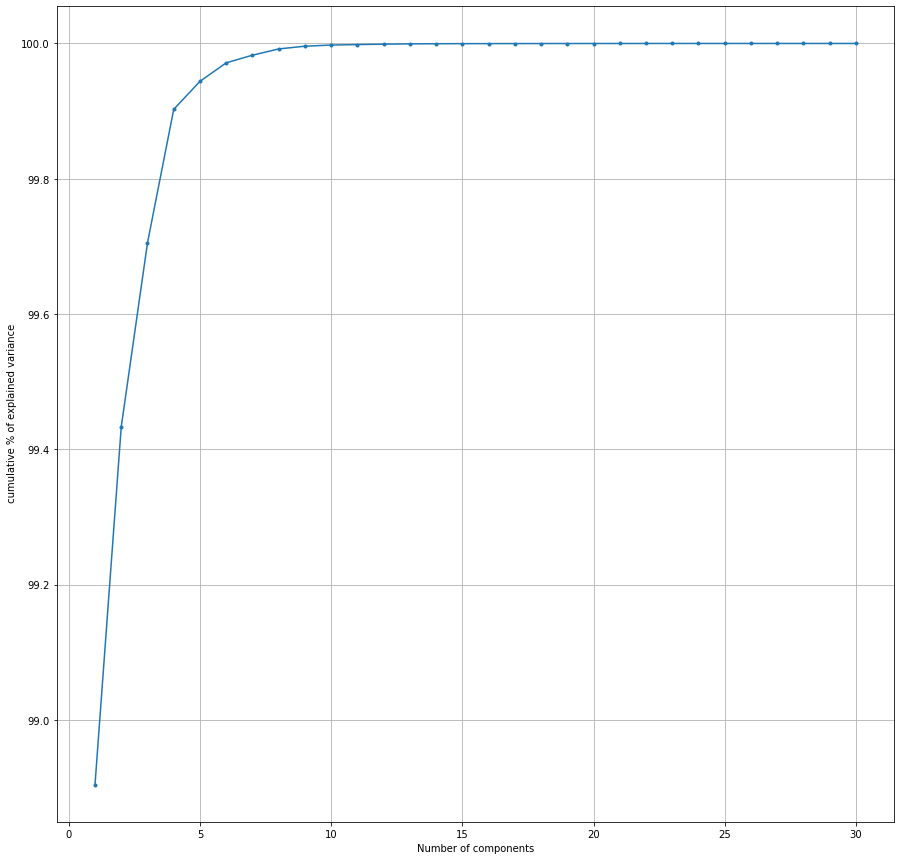

In [19]:
pca = PCA()
pca.fit(df_msc)
plt.figure(figsize=[15, 15])
plt.plot(
    range(1, len(pca.explained_variance_) + 1),
    100 * pca.explained_variance_.cumsum() / pca.explained_variance_.sum(),
    marker=".",
)
plt.grid(True)
plt.xlabel("Number of components")
plt.ylabel(" cumulative % of explained variance")
plt.show()

In [20]:
df_pca = pd.DataFrame(pca.transform(df_msc))
plt.figure(figsize=[15, 15])
plt.plot(df_pca.loc[:, 0:25].transpose())

plt.title("Transformed spectra PCA")
plt.ylabel("Response feature")
plt.xlabel("Principal component")
plt.grid(True)
plt.show()